# Part 1 - Supervised Contrastive learning  - Using new loss

## Supervised Contrastive Learning


### Set up

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Data Prep

In [5]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

### Building Encoder Model

In [23]:

def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


### Classification Model

In [24]:

def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [25]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 10)                5130      
                                                

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "cifar10-classifier" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 28)


### Supervised contrastive learning loss function

In [26]:

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

## Softmax Based Supervised Learning

In [10]:
!pip install tensorflow matplotlib

In [11]:
# Importing necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential


### Prepping the data

In [12]:
# Load dataset (e.g., MNIST)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


### Sequential Model

In [13]:
# Create a Sequential model
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.2545 - accuracy: 0.9267 - val_loss: 0.1362 - val_accuracy: 0.9591
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1101 - accuracy: 0.9671 - val_loss: 0.0987 - val_accuracy: 0.9684
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0764 - accuracy: 0.9768 - val_loss: 0.0822 - val_accuracy: 0.9739
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0568 - accuracy: 0.9823 - val_loss: 0.0732 - val_accuracy: 0.9769
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 0.0749 - val_accuracy: 0.9771
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0344 - accuracy: 0.9898 - val_loss: 0.0793 - val_accuracy: 0.9747
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0280 - accuracy: 0.9912 - val_loss: 0.0760 - val_accura

### Plotting

In [14]:
# Plotting function
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

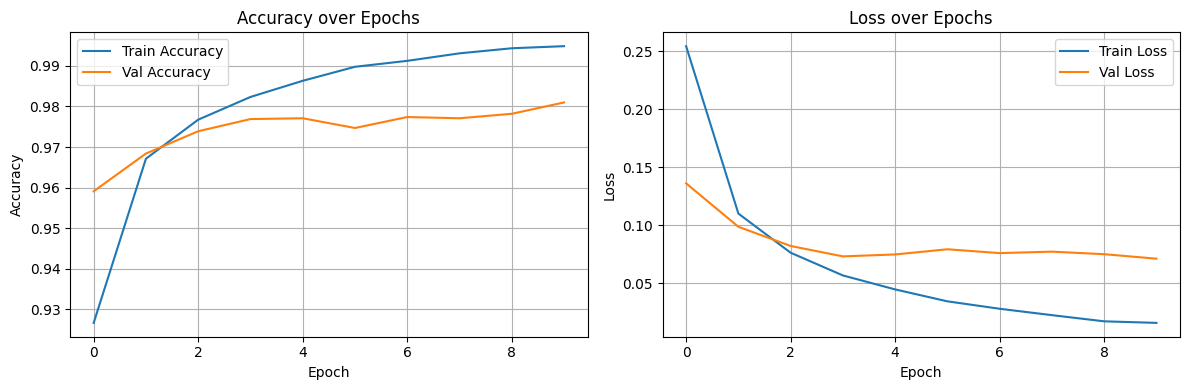

In [15]:
# Visualize the results
plot_metrics(history)

### Evaluation

In [16]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

313/313 - 1s - loss: 0.0712 - accuracy: 0.9810 - 522ms/epoch - 2ms/step

Test accuracy: 0.9810000061988831
